20.0


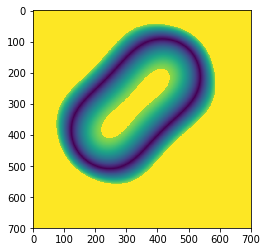

In [778]:
####################
# packages
####################
import numpy as np
import csv
import matplotlib.pyplot as plt
from skimage.draw import circle

####################
# load track data
####################
csv_file = open('track_data.txt', 'r')
csv_reader = csv.reader(csv_file, delimiter=' ')
track_data = next(csv_reader)

x_min = float(track_data[0])
x_max = float(track_data[1])
y_min = float(track_data[2])
y_max = float(track_data[3])
res = float(track_data[4])

width = int((x_max - x_min)*res)
height = int((y_max - y_min)*res)
track_costs = np.array(track_data[5:width*height+5]).astype('float')
track_costs = track_costs.reshape((width, height))

####################
# display track
####################
disp_costs = track_costs.copy()
disp_costs[disp_costs == 100.0] = 3
plt.imshow(disp_costs)
plt.show()

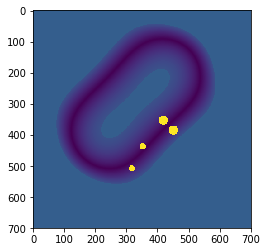

In [777]:
####################
# read gazebo world
####################
world = ET.parse('../../../../../../autorally_description/urdf/populated_obstacles_AR.world')
root = world.getroot()[0]

####################
# extract objects
####################
obj_dict = {}
for child in root.iter('include'):
    name = child.find('name')
    pose = child.find('pose')
    if name is not None:
        pose = np.fromstring(pose.text, sep=' ')
        obj_dict[name.text] = pose
        
####################
# find obstacles
####################
obs_dict = {}
for obj in obj_dict.keys():
    if obj.find('obstacle') != -1:
        obs_dict[obj] = obj_dict[obj][:2]

########################################
# transform object coordinates to index
########################################

'''
(x, y) in world frame becomes (y, -x) in the car frame (-90 deg rotation)
state estimator origin at car's fixed beginning location
offset by car's location in world frame after rotation to car frame
'''

world2map_rot = np.array([[0, -1],[1,0]])
world2map_offset = np.array([-8.77, 0.26])
world_offset = np.array([x_min, y_min])

def coord2idx(pos):
    idx = world2map_rot.dot(pos) + world2map_offset
    idx = ((idx-world_offset)*res).astype('int')
    return idx

#######################
# add obstacles to map
#######################
obs_track_costs = track_costs.copy()
#for obs in obs_dict:
coord = coord2idx(obs_dict['obstacle_1'])
circle_idx = circle(coord[1], coord[0], 15)
obs_track_costs[circle_idx] = 10.0

coord = coord2idx(obs_dict['obstacle_2'])
circle_idx = circle(coord[1], coord[0], 15)
obs_track_costs[circle_idx] = 10.0

coord = coord2idx(obs_dict['obstacle_3'])
circle_idx = circle(coord[1], coord[0], 10)
obs_track_costs[circle_idx] = 10.0

coord = coord2idx(obs_dict['obstacle_4'])
circle_idx = circle(coord[1], coord[0], 10)
obs_track_costs[circle_idx] = 10.0

###############################
# display obstacles with track
###############################
disp_costs = obs_track_costs.copy()
disp_costs[disp_costs == 100.0] = 3
plt.imshow(disp_costs)
plt.show()

#################################
# export cost map with obstacles
#################################
param_array = np.array([x_min, x_max, y_min, y_max, res])
obs_track_costs_with_param = np.concatenate((param_array, obs_track_costs.reshape(-1)), axis=0).reshape(1, -1)
np.savetxt('obstacle_track_data.txt', obs_track_costs_with_param, delimiter=' ', fmt='%.1f')